# Reconstruction - spherical model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch
import copy

from astropy     import units, constants
from pomme.model import TensorModel, SphericalModel
from pomme.loss  import Loss, diff_loss
from pomme.plot  import plot_cube_2D
from pomme.utils import planck, T_CMB

from spherical import lines, velocities, frequencies, smodel, r_out, get_turbulence, get_boundary_condition
from spherical import smodel as smodel_truth

/STER/frederikd/pomme/docs/src/examples/spherical/spherical.py:46: RuntimeWarning: divide by zero encountered in true_divide
  rho  = Mdot / (4.0 * np.pi * rs**2 * v)
/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol
You have selected line:
    CO(J=7-6)
Please check the properties that were inferred:
    Frequency         8.066518060e+11  Hz
    Einstein A coeff  3.422000000e-05  1/s
    Molar mass        28.0101          g/mol


In [2]:
obss = torch.load('obss.pt')

In [3]:
def get_velocity(model):
    """
    Get the velocity from the TensorModel.
    """
    return torch.exp(model['log_velocity'])


def get_temperature(model):
    """
    Get the temperature from the TensorModel.
    """
    return torch.exp(model['log_temperature'])


def get_abundance(model):
    """
    Get the abundance from the TensorModel.
    """
    return torch.exp(model['log_CO'])

In [4]:
r       = torch.exp(smodel_truth.model_1D['log_r'])
v_in    = torch.exp(smodel_truth.model_1D['log_v_in'])
v_inf   = torch.exp(smodel_truth.model_1D['log_v_inf'])
beta    = torch.exp(smodel_truth.model_1D['log_beta'])
R_star  = torch.exp(smodel_truth.model_1D['log_R_star'])
T_in    = torch.exp(smodel_truth.model_1D['log_T_in'])
epsilon = torch.exp(smodel_truth.model_1D['log_epsilon'])

# # Compute velocity
v = np.empty_like(r)
v[r <= R_star] = v_in
v[r >  R_star] = v_in + (v_inf - v_in) * (1.0 - R_star / r[r > R_star])**beta

# # Compute temperature
T = np.empty_like(r)    
T[r <= R_star] = T_in
T[r >  R_star] = T_in * (R_star / r[r > R_star])**epsilon

# Mdot = (1.0e-6 * units.M_sun / units.yr).si.value
# rho  = Mdot / (4.0 * np.pi * r**2 * v)
# n_CO = (3.0e-4 * constants.N_A.si.value / 2.02e-3) * rho
# n_CO[r <= R_star] = n_CO[n_CO<np.inf].max()

n_CO = 5.0e+14 * (smodel.rs.min()/smodel.rs)**2

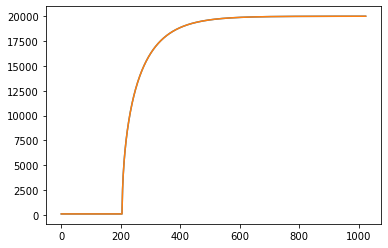

In [5]:
plt.plot(smodel_truth.get_velocity(smodel_truth.model_1D).data)
plt.plot(v)

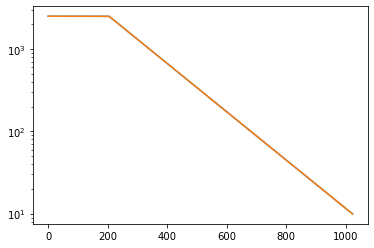

In [6]:
plt.plot(smodel_truth.get_temperature(smodel_truth.model_1D).data)
plt.plot(T)
plt.yscale('log')

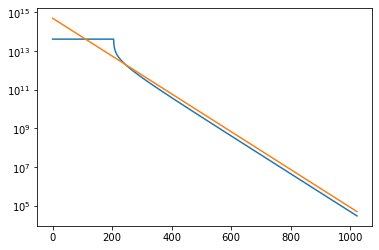

In [7]:
plt.plot(smodel_truth.get_abundance(smodel_truth.model_1D).data)
plt.plot(n_CO)
plt.yscale('log')

In [8]:
smodel = SphericalModel(
    rs       = smodel_truth.rs,
    model_1D = TensorModel.load('model_truth.h5'),
    r_star   = smodel_truth.r_star,
)
smodel.get_abundance          = get_abundance
smodel.get_velocity           = get_velocity
smodel.get_temperature        = get_temperature
smodel.get_turbulence         = get_turbulence
smodel.get_boundary_condition = get_boundary_condition

smodel.model_1D['log_CO'         ] = np.log(n_CO).copy()
smodel.model_1D['log_velocity'   ] = np.log(v   ).copy()
smodel.model_1D['log_temperature'] = np.log(T   ).copy()

del smodel.model_1D.vars['log_v_in']
del smodel.model_1D.vars['log_v_inf']
del smodel.model_1D.vars['log_beta']
del smodel.model_1D.vars['log_T_in']
del smodel.model_1D.vars['log_epsilon']

# smodel.model_1D.free(['log_CO', 'log_v_in', 'log_v_inf', 'log_beta', 'log_T_in', 'log_epsilon'])
smodel.model_1D.free(['log_CO', 'log_velocity', 'log_temperature'])

losses = Loss(['avg', 'rel', 'reg'])

In [9]:
smodel.model_1D.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.082e+01     +2.233e+01     +3.385e+01
  log_R_star                 Fixed         False    +2.573e+01     +2.573e+01     +2.573e+01
  log_T_star                 Fixed         False    +7.824e+00     +7.824e+00     +7.824e+00
  log_r                      Fixed         True     +2.343e+01     +2.919e+01     +3.494e+01
  log_turbulence             Fixed         True     +6.908e+00     +6.908e+00     +6.908e+00
  log_velocity               Free          True     +4.605e+00     +8.772e+00     +9.903e+00
  log_temperature            Free          True     +2.298e+00     +5.613e+00     +7.824e+00
sizes: [1.49597871e+15]
shape: (1024,)


In [10]:
imgs = smodel.image(lines, frequencies, r_max=r_out)

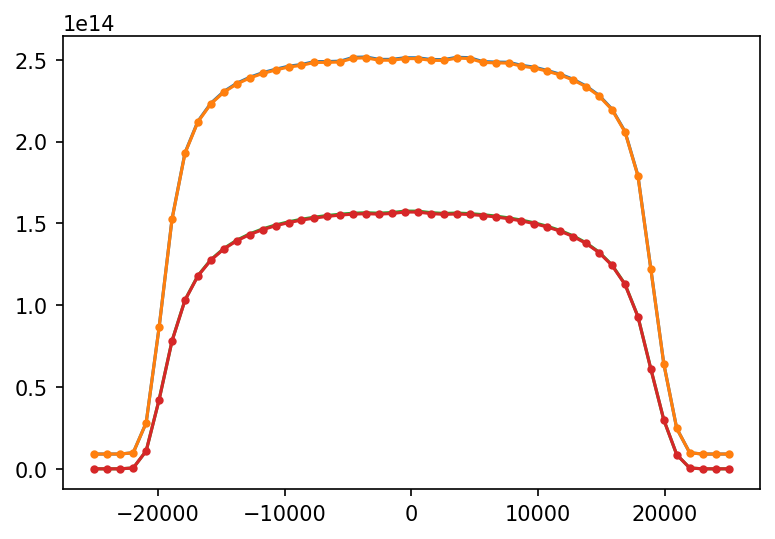

In [11]:
plt.figure(dpi=150)
for obs, img in zip(obss, imgs):
    plt.plot(velocities, obs.data)
    plt.plot(velocities, img.data, marker='.')

In [12]:
# def steady_state_cont_loss(smodel):
#     """
#     Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
#     """
#     # Get a mask for the elements outsife the star
#     outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        
#     # Get the model variables
#     rho = smodel.get_abundance(smodel.model_1D)[outside_star]
#     v_r = smodel.get_velocity (smodel.model_1D)[outside_star]
#     r   = torch.from_numpy(smodel.rs)          [outside_star]

#     # Continuity equation (steady state): div(ρ v) = 0
#     loss_cont = smodel.diff_r(r**2 * rho * v_r, r)

#     # Compute the mean squared losses
#     loss = torch.mean((loss_cont/((r**2)*rho))**2)
#     # Return losses
#     return loss

In [13]:
from torch.optim import Adam
from tqdm        import tqdm

obss_avg = obss.mean(axis=1)
obss_rel = torch.einsum("ij, i -> ij", obss, 1.0 / obss.mean(axis=1))

# Get a mask for the elements outsife the star
outside_star = torch.from_numpy(smodel.rs) > torch.exp(smodel.model_1D['log_R_star'])
        

def fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0, w_rel=1.0, w_reg=1.0, w_cnt=1.0):

    params = [
        smodel.model_1D['log_CO'],
        smodel.model_1D['log_temperature'],
        smodel.model_1D['log_velocity'],
        # smodel.model_1D['log_v_in'],
        # smodel.model_1D['log_v_inf'],
        # smodel.model_1D['log_beta'],
        # smodel.model_1D['log_T_in'],
        # smodel.model_1D['log_epsilon'],
    ]

    abundance_evol = [smodel.get_abundance(smodel.model_1D).detach().clone()]
    
    optimizer = Adam(params, lr=lr)

    for _ in tqdm(range(N_epochs)):

        # Forward model
        imgs = smodel.image(lines, frequencies, r_max=r_out)

        imgs_avg= imgs.mean(axis=1)
        imgs_rel= torch.einsum("ij, i -> ij", imgs, 1.0 / imgs.mean(axis=1))

        # Compute the reproduction loss
        losses['avg'] = w_avg * torch.nn.functional.mse_loss(imgs_avg, obss_avg)
        losses['rel'] = w_rel * torch.nn.functional.mse_loss(imgs_rel, obss_rel)
        # Compute the regularisation loss
        losses['reg'] = w_reg * (   diff_loss(smodel.model_1D['log_CO'         ][outside_star]) \
                                  + diff_loss(smodel.model_1D['log_velocity'   ][outside_star]) \
                                  + diff_loss(smodel.model_1D['log_temperature'][outside_star]) )
        # Compute the regularisation loss
        # losses['reg'] = w_reg * (   diff_loss(smodel.model_1D['log_CO'         ][outside_star]) )
        # Compute the regularisation loss
        # losses['reg'] = w_reg * (   diff_loss(smodel.model_1D['log_CO'         ]) \
        #                           + diff_loss(smodel.model_1D['log_velocity'   ]) \
        #                           + diff_loss(smodel.model_1D['log_temperature']) )
        # Compute the hydrodynamic loss   
        # losses['cnt'] = w_cnt * steady_state_cont_loss(smodel)   

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        losses.tot().backward()
        # Update parameters
        optimizer.step()

        abundance_evol.append(smodel.get_abundance(smodel.model_1D).detach().clone())

    return imgs, losses, abundance_evol

In [14]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=3, lr=1.0e-1, w_avg=1.0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

losses.renormalise_all()
losses.reset()

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [01:11<00:00, 23.67s/it]


In [15]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=10, lr=1.0e-1, w_avg=1.0e+0, w_rel=1.0e+0, w_reg=1.0e-0, w_cnt=1.0e+0)

100%|██████████| 10/10 [04:36<00:00, 27.61s/it]


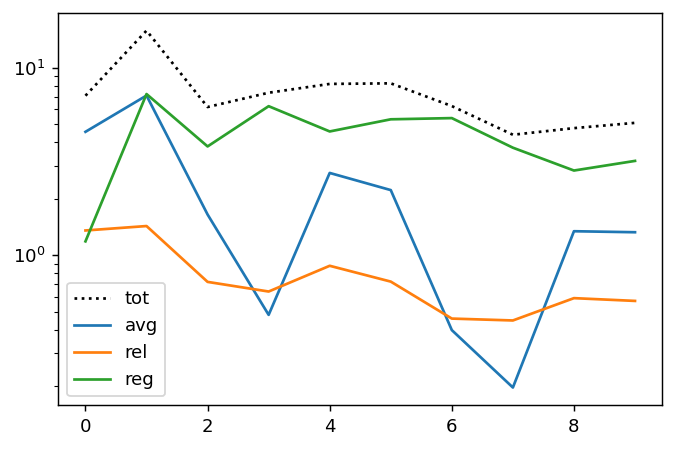

In [16]:
losses.plot()

In [17]:
imgs, losses, a_evol = fit(losses, smodel, lines, frequencies, obss, N_epochs=500, lr=1.0e-1, w_avg=1.0e+0, w_rel=1.0e+0, w_reg=1.0e+0, w_cnt=1.0e+0)

100%|██████████| 500/500 [2:10:51<00:00, 15.70s/it]  


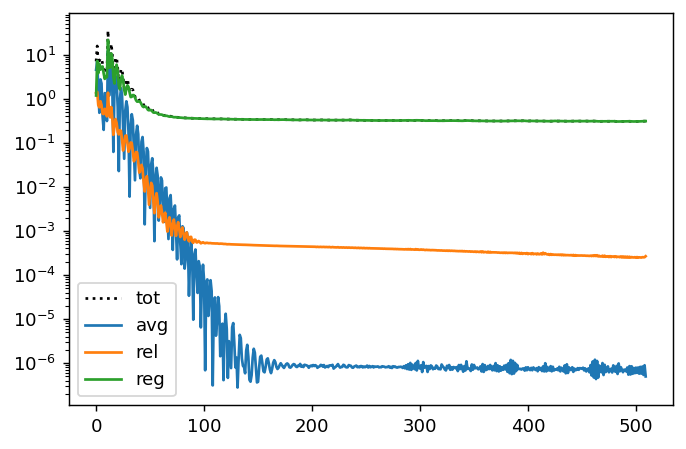

In [19]:
losses.plot()

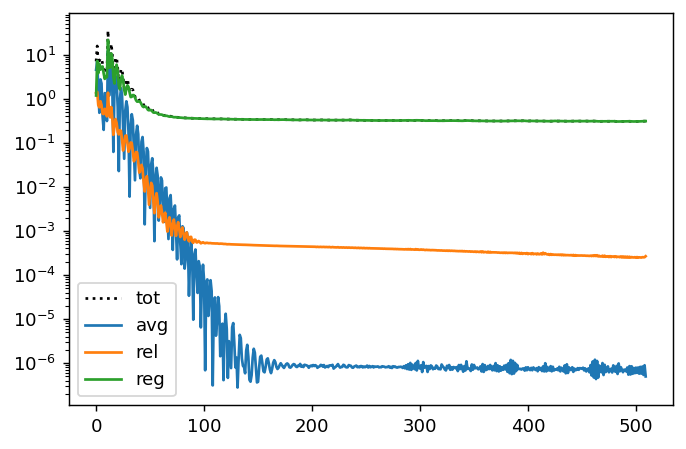

In [20]:
losses.plot()
plt.savefig(f'everything/losses_2_noco.png')

torch.save(imgs, f'everything/imgs_noco.pt')

smodel.model_1D.save(f'everything/model_noco.h5')